# Data Exploration for the Kaggle Steel Detection Competition

## import modules and define models

In [1]:
import numpy as np # linear algebra
import pandas as pd
pd.set_option("display.max_rows", 101)
import os
#print(os.listdir(".."))
print(os.listdir("./input/severstal-steel-defect-detection"))
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import seaborn as sns
from collections import Counter
from PIL import Image
import math
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import cv2
from tqdm import tqdm

['.ipynb_checkpoints', 'sample_submission.csv', 'test_images', 'train.csv', 'train_images']


In [2]:
input_dir = "./input/severstal-steel-defect-detection"

## read all text data
#### file description
* train_images/ - folder of training images
* test_images/ - folder of test images (you are segmenting and classifying these images)
* train.csv - training annotations which provide segments for defects (ClassId = [1, 2, 3, 4])
* sample_submission.csv - a sample submission file in the correct format; note, **each ImageId 4 rows, one for each of the 4 defect classes**

In [3]:
train_df = pd.read_csv("./input/severstal-steel-defect-detection/train.csv")
#sample_df = pd.read_csv("./input/severstal-steel-defect-detection/sample_submission.csv")

In [4]:
train_df.head()

ImageId_ClassId                                      EncodedPixels
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg_2                                                NaN
2  0002cc93b.jpg_3                                                NaN
3  0002cc93b.jpg_4                                                NaN
4  00031f466.jpg_1                                                NaN

In [5]:
#sample_df.head()

### First, check the number of each class.

In [6]:
class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
    
    kind_class_dict[sum(labels.isna().values == False)] += 1
        
    for idx, label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx+1] += 1

In [7]:
print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

the number of images with no defects: 5902
the number of images with defects: 6666


defaultdict(int, {1: 897, 3: 5150, 4: 801, 2: 247})

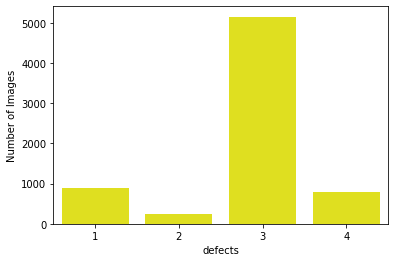

In [8]:
fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), color="yellow", ax=ax)
#ax.set_title("Images with defect")
ax.set_xlabel("defects")
ax.set_ylabel("Number of Images")
class_dict

defaultdict(int, {1: 6239, 0: 5902, 2: 425, 3: 2})

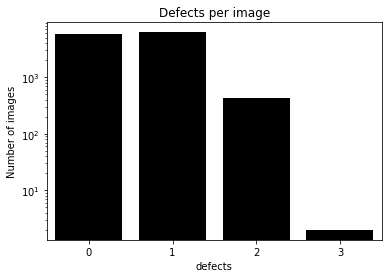

In [9]:
fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), color = "black", ax=ax, log=True)
ax.set_title("Defects per image");
ax.set_xlabel("defects")
ax.set_ylabel("Number of images")
kind_class_dict

## Training data
### Preprocessing: Resize if necessary.

In [10]:
train_size_dict = defaultdict(int)
train_path = Path("./input/severstal-steel-defect-detection/train_images")

for img_name in train_path.iterdir():
    img = Image.open(img_name)
    train_size_dict[img.size] += 1

In [11]:
train_size_dict

defaultdict(int, {(1600, 256): 12568})

In [12]:
test_size_dict = defaultdict(int)
test_path = Path("./input/severstal-steel-defect-detection/test_images/")

for img_name in test_path.iterdir():
    img = Image.open(img_name)
    test_size_dict[img.size] += 1

In [13]:
test_size_dict

defaultdict(int, {(1600, 256): 1801})

# DEFECT VISUALIZATION STAGE USING openCV

In [14]:
palet = [(200, 202, 28), (0, 185, 241), (114, 0, 218), (249,50,12)]

In [15]:
def name_and_mask(start_idx):
    col = start_idx
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError

    labels = train_df.iloc[col:col+4, 1]
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
    return img_names[0], mask

In [16]:
def show_mask_image(col):
    name, mask = name_and_mask(col)
    img = cv2.imread(str(train_path / name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

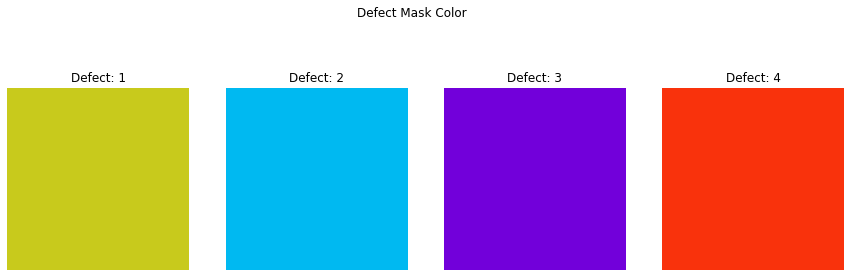

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("Defect: {}".format(i+1))
fig.suptitle("Defect Mask Color")

plt.show()

In [18]:
idx_no_defect = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_multi = []
idx_class_triple = []

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        idx_no_defect.append(col)
    elif (labels.isna() == [False, True, True, True]).all():
        idx_class_1.append(col)
    elif (labels.isna() == [True, False, True, True]).all():
        idx_class_2.append(col)
    elif (labels.isna() == [True, True, False, True]).all():
        idx_class_3.append(col)
    elif (labels.isna() == [True, True, True, False]).all():
        idx_class_4.append(col)
    elif labels.isna().sum() == 1:
        idx_class_triple.append(col)
    else:
        idx_class_multi.append(col)

## NO DEFECTS CLASS

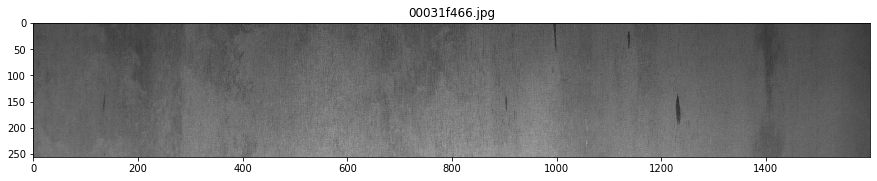

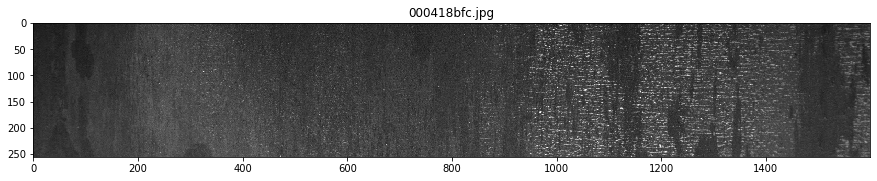

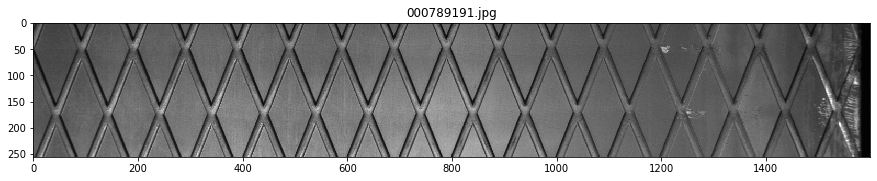

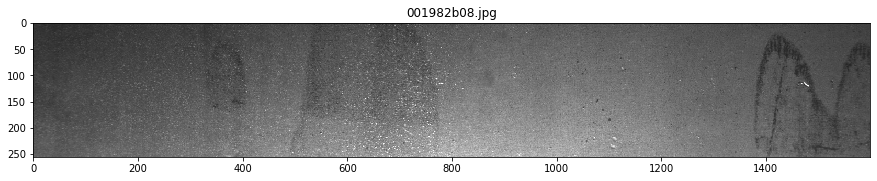

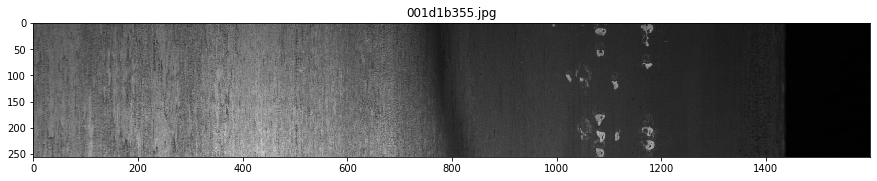

In [19]:
for idx in idx_no_defect[:5]:
    show_mask_image(idx)

## DEFECT CLASS 1

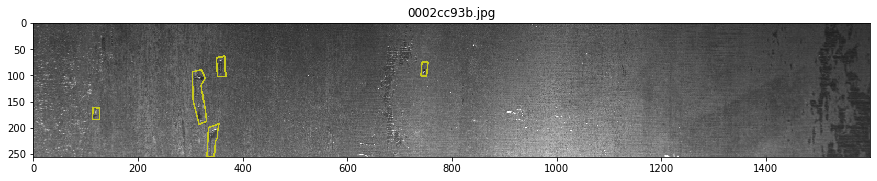

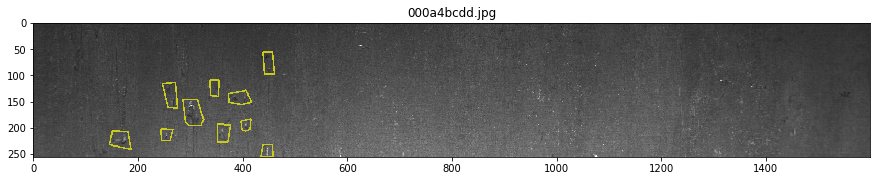

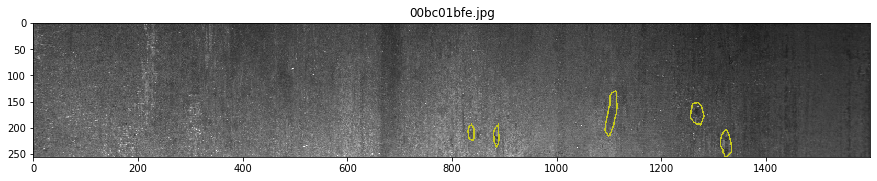

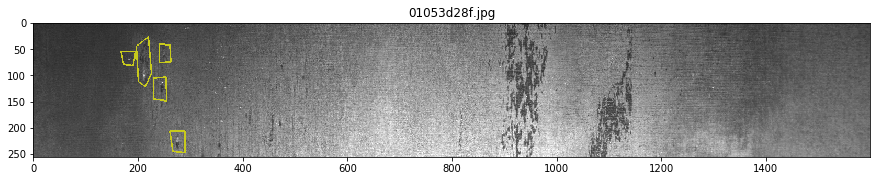

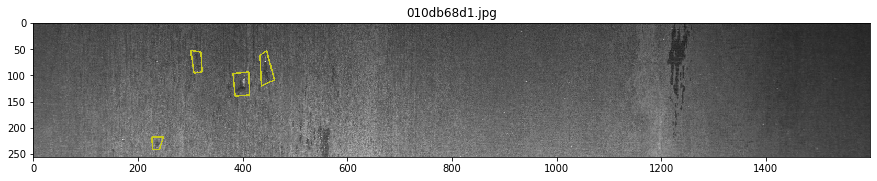

In [20]:
for idx in idx_class_1[:5]:
    show_mask_image(idx)

## DEFECT CLASS 2

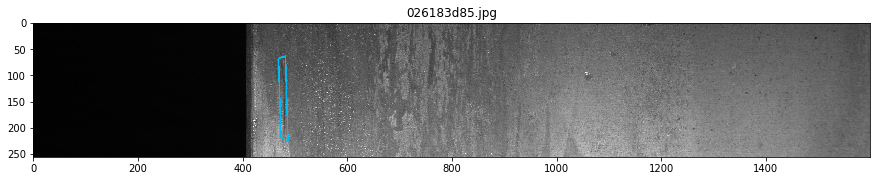

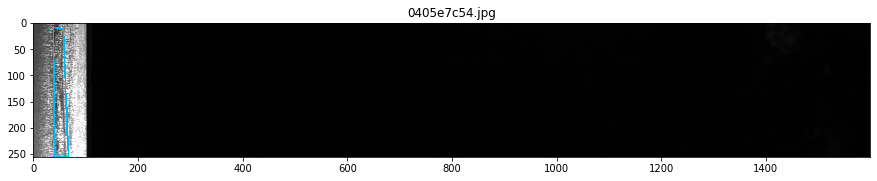

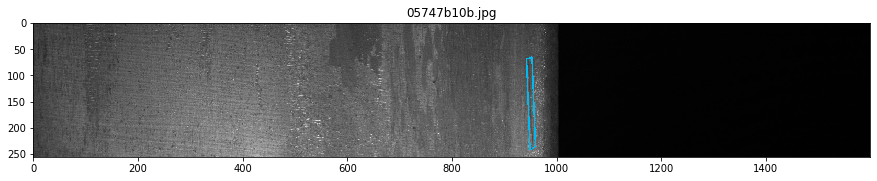

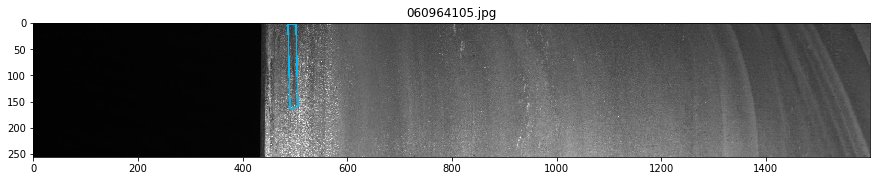

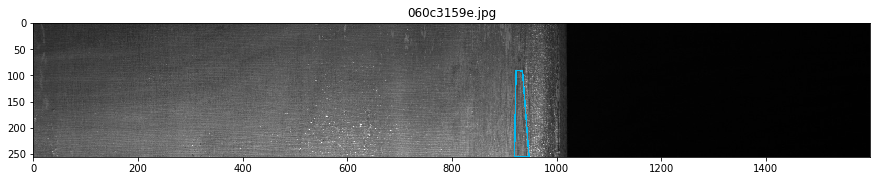

In [21]:
for idx in idx_class_2[:5]:
    show_mask_image(idx)

## DEFECT CLASS 3

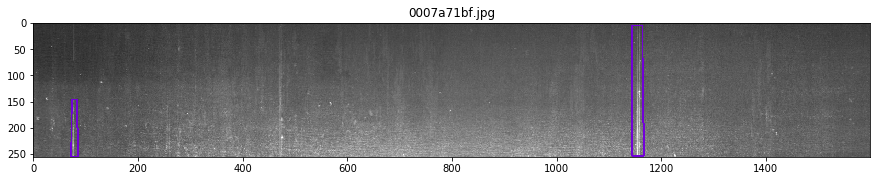

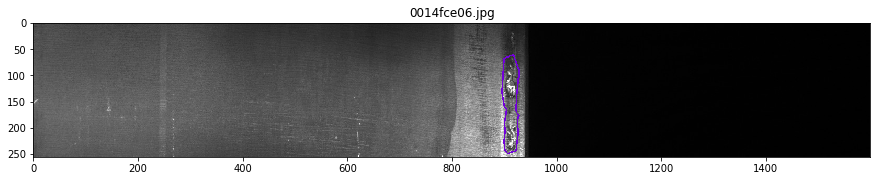

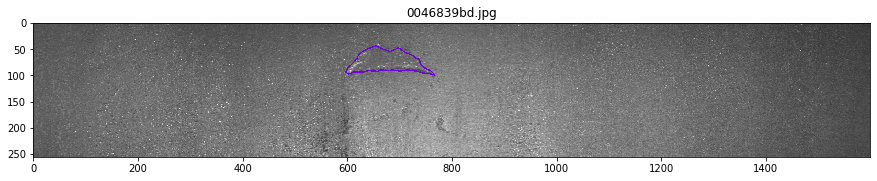

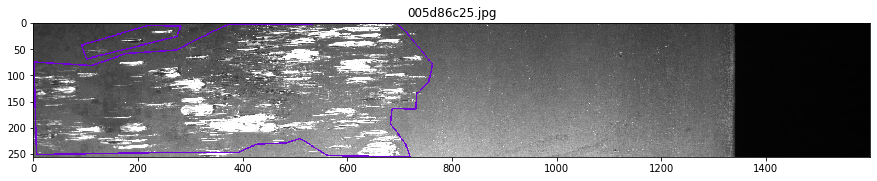

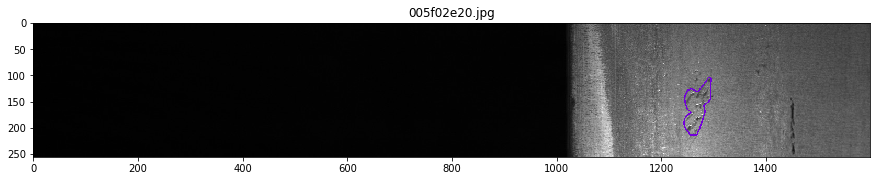

In [22]:
for idx in idx_class_3[:5]:
    show_mask_image(idx)

## DEFECT CLASS 4

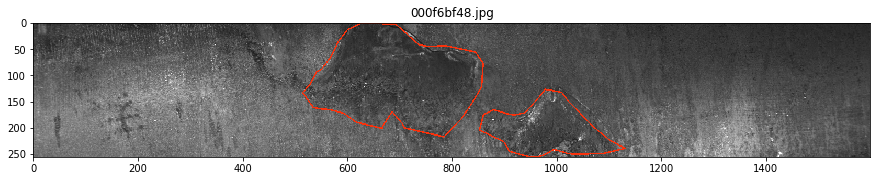

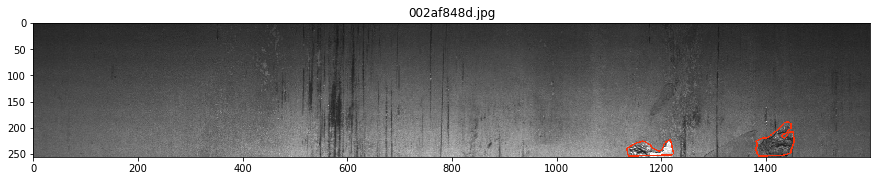

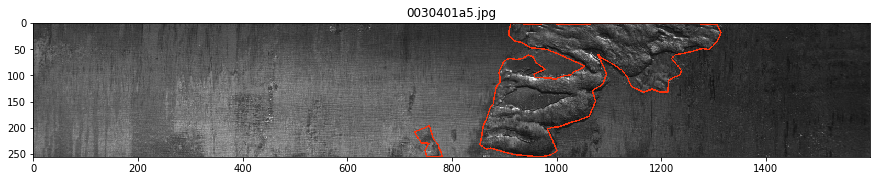

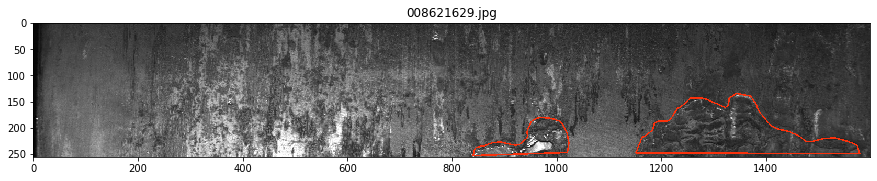

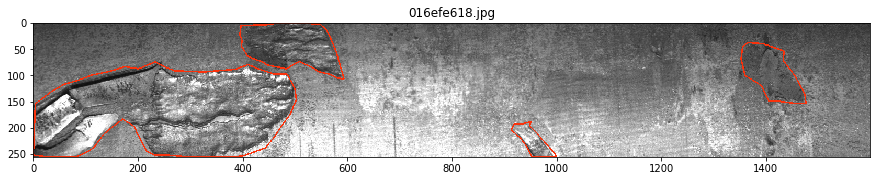

In [23]:
for idx in idx_class_4[:5]:
    show_mask_image(idx)

## IMAGES WITH 2 DEFECTS

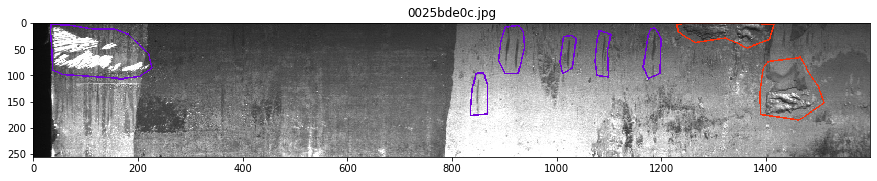

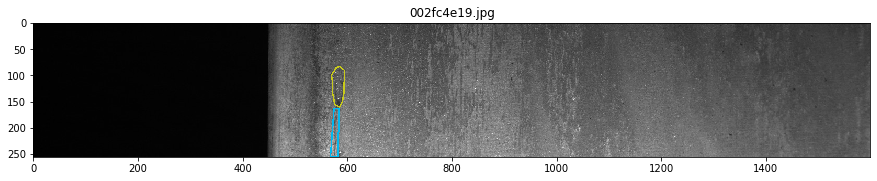

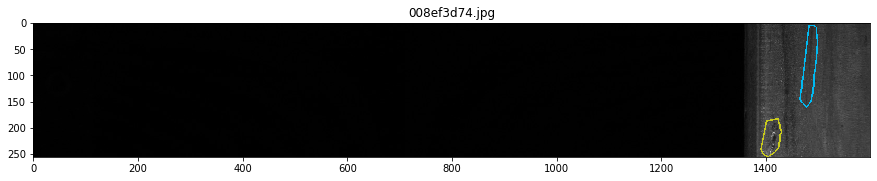

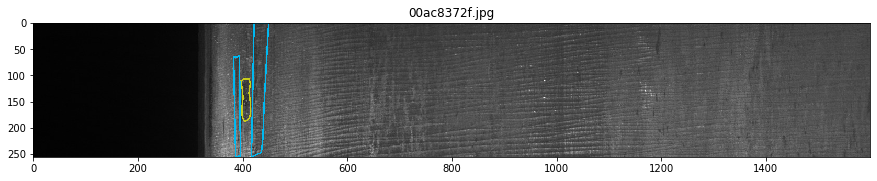

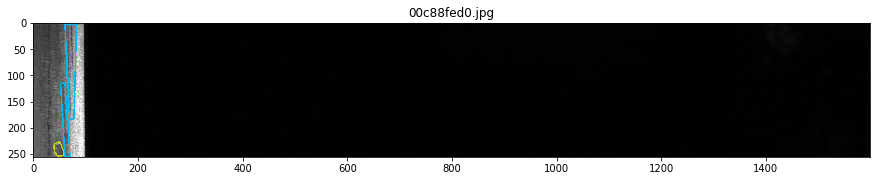

In [24]:
for idx in idx_class_multi[:5]:
    show_mask_image(idx)

## IMAGES WITH 3 DEFECTS

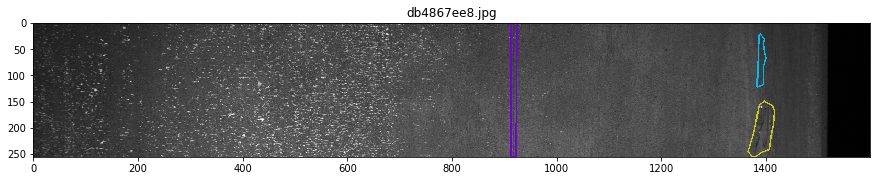

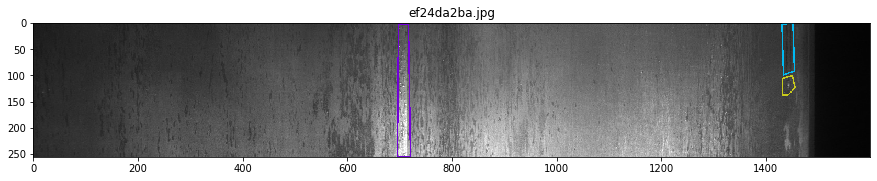

In [25]:
for idx in idx_class_triple:
    show_mask_image(idx)

* We can see 4 type defect

# ERROR HANDLING

In [23]:
for col in tqdm(range(0, len(train_df), 4)):
    name, mask = name_and_mask(col)
    if (mask.sum(axis=2) >= 2).any():
        show_mask_image(col)

100%|███████████████████████████████████████████████████████████████████████████| 12568/12568 [01:34<00:00, 132.50it/s]


* All pixels have 1 or less label.